In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2, mutual_info_classif
from sklearn.metrics import *
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.stats import norm
from sklearn.svm import SVC
from sklearn.utils import resample # permet de faire du rééchantillonage
import warnings
import math

In [2]:
data_train = pd.read_csv("sets/train.csv")
dataframe = data_train.copy()
data_test = pd.read_csv("sets/test.csv")
testset = data_test.copy()

pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings("ignore")

print(dataframe.columns)
print(testset.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')
Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')


# **Preprocessing & Modelisation**
## **1. Data Preprocessing**
- ### Feature Engineering : 

In [3]:
def feature_engineering(df):
    print("feature engineering")

    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

    df["pickup_month"] = df["pickup_datetime"].dt.month
    df["pickup_weekday"] = df["pickup_datetime"].dt.weekday
    df["pickup_day"] = df["pickup_datetime"].dt.day
    df["pickup_hour"] = df["pickup_datetime"].dt.hour
    df["pickup_dayofyear"] = df["pickup_datetime"].dt.dayofyear
    df["pickup_minute"] = df["pickup_datetime"].dt.minute

    df["latitude_difference"] = df["dropoff_latitude"] - df["pickup_latitude"]
    df["longitude_difference"] = df["dropoff_longitude"] - df["pickup_longitude"]
    
    df["sphere_square_length"] = np.sin(df["latitude_difference"]/2)**2 + np.cos(np.radians(df["pickup_latitude"])) * np.cos(np.radians(df["dropoff_latitude"])) * np.sin(df["longitude_difference"]/2)**2
    df["sphere_square_length"] = np.clip(df["sphere_square_length"], 0, 1 - 1e-10)
    df["trip_angle"] =  2 * np.arctan2(np.sqrt(df["sphere_square_length"]), np.sqrt(1 - df["sphere_square_length"]))
    df["trip_length"] = 6371e3 * df["trip_angle"]

    X = df.select_dtypes(exclude=["object", "datetime"]).drop(["trip_duration"], axis=1)
    """
    K_range = range(1, 20)
    inertia = []
    for k in K_range:
        model = KMeans(n_clusters=k).fit(X)
        inertia.append(model.inertia_)

    plt.plot(K_range, inertia)
    plt.xlabel("Nombre de clusters")
    plt.ylabel("Cout du model (intertia)")"""

    model = KMeans(n_clusters=12).fit(X)
    df["X_cluster"] = model.predict(X)

    return df

- ### Encodage : 
    - pas de normalisation ou standardisation, ça génère des NaN car il y a trop peu de variance dans les variables continues

In [4]:
def encodage(df):
    print("Encodage")

    df = df.astype({col : "float32" for col in df.select_dtypes(exclude=["object", "datetime"]).columns})

    for col in df.select_dtypes(["object", "datetime"]):
        df[col] = df[col].astype("category").cat.codes
        df[col] = df[col].replace(-1, np.nan)

    return df

- ### Selection des variables : 

In [5]:
def select_var(df):
    return df

- ### Imputation : 

In [6]:
def imputation(df):
    print("imputation")

    drop_features = ["id", "pickup_datetime", "dropoff_datetime", "store_and_fwd_flag"]
    for col in drop_features:
        df = df.drop(col, axis=1)

    outliers = df[df["trip_duration"] > 1e6]
    df = df.drop(outliers.index, axis=0)

    return df

- ### Transformation : 
    - trip_duration : log
    - pickup_longitude : cos
    - dropoff_longitude : cos
    - pickup_latitude : sin
    - dropoff_latitude : sin
    - trip_length : cbrt
    - trip_angle : cbrt

In [7]:
pt = PowerTransformer(method="yeo-johnson")
def transformation(df):
    print("transformation")

    df["trip_duration"] = np.log(df["trip_duration"])
    df[["pickup_longitude", "dropoff_longitude"]] = np.cos(df[["pickup_longitude", "dropoff_longitude"]])
    df[["pickup_latitude", "dropoff_latitude"]] = np.sin(df[["pickup_latitude", "dropoff_latitude"]])
    #df[["trip_length"]] = np.cbrt(df[["trip_length"]])
    #df[trip_angle] = np.cbrt(df[trip_angle])

    """
    col = "trip_angle"
    df[col] = np.cbrt(df[col])

    anderson = stats.anderson(df[col], dist="norm")
    print(f"{col} : ", anderson.statistic)"""

    return df

- ### Train-Test split : 

In [8]:
trainset, testset = train_test_split(dataframe, test_size=0.2, random_state=0)

- ### Preprocessing : 

In [9]:
def preprocessing(df):
    df = feature_engineering(df)
    df = encodage(df)
    df = select_var(df)
    df = imputation(df)
    df = transformation(df)

    X = df.drop("trip_duration", axis=1)
    y = df["trip_duration"]

    return X, y

X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

feature engineering
Encodage
imputation
transformation
feature engineering
Encodage
imputation
transformation


- ### Transformation Inversion : 

In [10]:
def transformation_inversion(y_test, y_pred):
    y_test = np.exp(y_test)
    y_pred = np.exp(y_pred)

    y_test = np.maximum(0, y_test) # valeur minimum de 0
    y_pred = np.maximum(0, y_pred)

    return y_test, y_pred

## **2. Modelisation**
- ### Model : 

In [92]:
model = LGBMRegressor(boosting_type='gbdt', num_leaves=100, max_depth=-1, learning_rate=0.25, n_estimators=120, subsample_for_bin=200000, 
                      objective=None, class_weight=None, min_split_gain=0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                      subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=0, n_jobs=None, importance_type='split')

- ### Evaluation : 
    - Score : 0.7357
    - RMSLE : 0.3906

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2629
[LightGBM] [Info] Number of data points in the train set: 1166912, number of used features: 18
[LightGBM] [Info] Start training from score 6.464350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2628
[LightGBM] [Info] Number of data points in the train set: 87518, number of used features: 18
[LightGBM] [Info] Start training from score 6.460401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2630
[LightGBM] [Info] Number of data points in the train set: 175036, number of used features: 18
[LightGBM] [Info] Start 

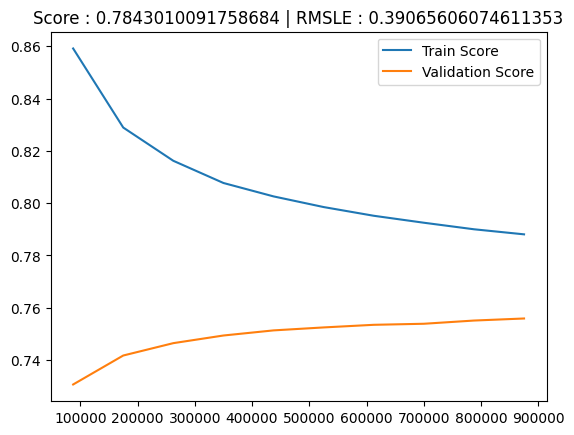

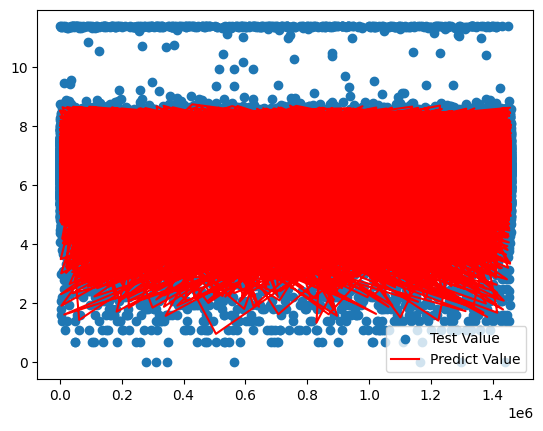

In [93]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_test_inv, y_pred_inv = transformation_inversion(y_test, y_pred)

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, train_sizes=np.linspace(0.1, 1, 10))

    plt.figure()
    plt.plot(N, train_score.mean(axis=1), label="Train Score")
    plt.plot(N, val_score.mean(axis=1), label="Validation Score")
    plt.title(f"Score : {model.score(X_train, y_train)} | RMSLE : {root_mean_squared_log_error(y_test_inv, y_pred_inv)}")
    plt.legend()

    plt.figure()
    plt.scatter(X_test.index, y_test, label="Test Value")
    plt.plot(X_test.index, y_pred, label="Predict Value", c="r")
    plt.legend()

evaluation(model)